In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

def parse_filename(filepath):
    """Parse filename to extract room_type, scan_type, and trial_number"""
    filename = filepath.stem.replace('_cleaned', '')
    
    # Split and take first part as room type
    parts = filename.split('_')
    room_type = parts[0]
    remainder = '_'.join(parts[1:])
    
    remainder_parts = remainder.split('_')
    
    if len(remainder_parts) == 1:
        scan_type = 'base'
        trial_number = int(remainder_parts[0])
    elif len(remainder_parts) == 2:
        scan_type = remainder_parts[0]
        trial_number = int(remainder_parts[1])
    else:
        scan_type = 'unknown'
        trial_number = -1
    
    return room_type, scan_type, trial_number

# Scan all CSV files
cleaned_path = Path("meta_scan_csvs/cleaned")
csv_files = list(cleaned_path.rglob("*.csv"))

# Group by room type
stats_by_room = {}

for csv_file in csv_files:
    room_type, scan_type, trial_number = parse_filename(csv_file)
    
    # Load data
    df = pd.read_csv(csv_file)
    if 'Time (s)' in df.columns:
        df = df.drop('Time (s)', axis=1)
    
    # Accumulate data by room type
    if room_type not in stats_by_room:
        stats_by_room[room_type] = []
    stats_by_room[room_type].append(df)

print(f"Found room types: {list(stats_by_room.keys())}")

# Compute statistics for each room type
room_stats = {}
for room_type, dfs in stats_by_room.items():
    combined = pd.concat(dfs, ignore_index=True)
    room_stats[room_type] = {
        'mean': combined.mean(),
        'std': combined.std(),
    }

# Analyze feature separation
feature_separation = {}
all_features = room_stats[list(room_stats.keys())[0]]['mean'].index

for feature in all_features:
    means = [room_stats[room]['mean'][feature] for room in room_stats.keys()]
    # Coefficient of variation of means = separation ability
    feature_separation[feature] = np.std(means) / (np.mean(np.abs(means)) + 1e-10)

# Sort by separation
top_features = sorted(feature_separation.items(), key=lambda x: x[1], reverse=True)[:15]

print("\n" + "=" * 80)
print("TOP 15 FEATURES FOR ROOM TYPE DIFFERENTIATION")
print("=" * 80)
for i, (feature, score) in enumerate(top_features, 1):
    print(f"{i:2d}. {feature:50s} (score: {score:.4f})")

# Show means for top 5
print("\n" + "=" * 80)
print("MEAN VALUES FOR TOP 5 FEATURES BY ROOM TYPE")
print("=" * 80)
for feature, _ in top_features[:5]:
    print(f"\n{feature}:")
    for room in sorted(room_stats.keys()):
        mean_val = room_stats[room]['mean'][feature]
        std_val = room_stats[room]['std'][feature]
        print(f"  {room:10s}: {mean_val:12.4f} ± {std_val:10.4f}")

In [1]:
from pathlib import Path
import pandas as pd

def parse_filename(filepath):
    filename = filepath.stem.replace('_cleaned', '')
    parts = filename.split('_')
    room_type = parts[0]
    remainder = '_'.join(parts[1:])
    remainder_parts = remainder.split('_')
    
    if len(remainder_parts) == 1:
        scan_type = 'base'
        trial_number = int(remainder_parts[0])
    elif len(remainder_parts) == 2:
        scan_type = remainder_parts[0]
        trial_number = int(remainder_parts[1])
    else:
        scan_type = 'unknown'
        trial_number = -1
    
    return room_type, scan_type, trial_number

# Scan all CSV files
cleaned_path = Path("meta_scan_csvs/cleaned")
csv_files = list(cleaned_path.rglob("*.csv"))

# Create metadata
metadata = []
for csv_file in csv_files:
    room_type, scan_type, trial_number = parse_filename(csv_file)
    metadata.append({
        'filepath': str(csv_file),
        'filename': csv_file.name,
        'room_type': room_type,
        'scan_type': scan_type,
        'trial_number': trial_number,
        'folder': csv_file.parent.name
    })

metadata_df = pd.DataFrame(metadata)
metadata_df['strata'] = metadata_df['room_type'] + '_' + metadata_df['scan_type']

print("=" * 80)
print("DATA SUMMARY")
print("=" * 80)
print(f"\nTotal files: {len(metadata_df)}")
print("\nFiles by room and scan type:")
print(metadata_df.groupby(['room_type', 'scan_type']).size().unstack(fill_value=0))

# Manual stratified split (~80/20)
train_indices = []
test_indices = []

for strata in metadata_df['strata'].unique():
    strata_df = metadata_df[metadata_df['strata'] == strata]
    n = len(strata_df)
    n_test = max(1, round(n * 0.2))
    n_train = n - n_test
    
    shuffled = strata_df.sample(frac=1, random_state=42)
    test_indices.extend(shuffled.index[:n_test].tolist())
    train_indices.extend(shuffled.index[n_test:].tolist())

train_df = metadata_df.loc[train_indices]
test_df = metadata_df.loc[test_indices]

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT")
print("=" * 80)
print(f"Training files: {len(train_df)} ({len(train_df)/len(metadata_df)*100:.1f}%)")
print(f"Testing files: {len(test_df)} ({len(test_df)/len(metadata_df)*100:.1f}%)")

print("\nTraining distribution:")
print(train_df.groupby(['room_type', 'scan_type']).size().unstack(fill_value=0))

print("\nTesting distribution:")
print(test_df.groupby(['room_type', 'scan_type']).size().unstack(fill_value=0))

# Save splits
train_df.to_csv("meta_scan_csvs/train_metadata.csv", index=False)
test_df.to_csv("meta_scan_csvs/test_metadata.csv", index=False)

print("\n✓ Saved train_metadata.csv and test_metadata.csv")

DATA SUMMARY

Total files: 75

Files by room and scan type:
scan_type  base  motion  object  person
room_type                              
blinds        0       5       5       5
hallway       5       5       5       5
kitchen       7       5       5       4
lab           5       5       5       4

TRAIN/TEST SPLIT
Training files: 60 (80.0%)
Testing files: 15 (20.0%)

Training distribution:
scan_type  base  motion  object  person
room_type                              
blinds        0       4       4       4
hallway       4       4       4       4
kitchen       6       4       4       3
lab           4       4       4       3

Testing distribution:
scan_type  base  motion  object  person
room_type                              
blinds        0       1       1       1
hallway       1       1       1       1
kitchen       1       1       1       1
lab           1       1       1       1

✓ Saved train_metadata.csv and test_metadata.csv


NameError: name 'cm' is not defined

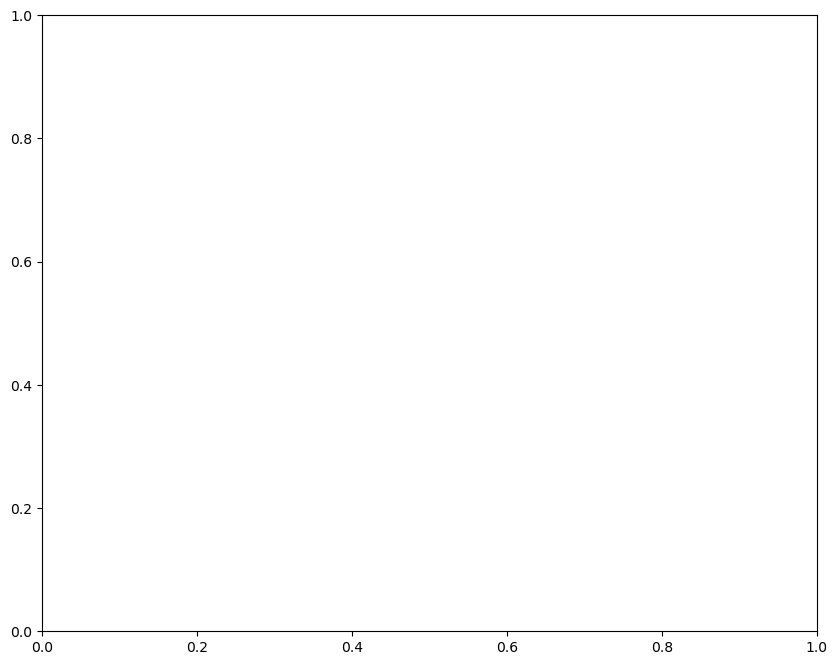

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Ticks and labels
ax.set_xticks(np.arange(len(room_types)))
ax.set_yticks(np.arange(len(room_types)))
ax.set_xticklabels(room_types)
ax.set_yticklabels(room_types)

plt.xlabel("Predicted")
plt.ylabel("Actual")

# Rotate x-labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add numbers to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


GRADIENT BOOSTING CLASSIFIER WITH FEATURE ENGINEERING

PROCESSING TRAIN SET

blinds_motion_5_cleaned.csv: 327 rows → 11 windows
blinds_motion_3_cleaned.csv: 335 rows → 11 windows
blinds_motion_1_cleaned.csv: 1838 rows → 71 windows
blinds_motion_4_cleaned.csv: 312 rows → 10 windows
blinds_object_5_cleaned.csv: 1827 rows → 71 windows
blinds_object_3_cleaned.csv: 327 rows → 11 windows
blinds_object_1_cleaned.csv: 1821 rows → 70 windows
blinds_object_4_cleaned.csv: 325 rows → 11 windows
blinds_person_5_cleaned.csv: 327 rows → 11 windows
blinds_person_3_cleaned.csv: 326 rows → 11 windows
blinds_person_1_cleaned.csv: 350 rows → 12 windows
blinds_person_4_cleaned.csv: 312 rows → 10 windows
hallway_5_cleaned.csv: 1493 rows → 57 windows
hallway_3_cleaned.csv: 306 rows → 10 windows
hallway_1_cleaned.csv: 300 rows → 10 windows
hallway_4_cleaned.csv: 320 rows → 10 windows
hallway_motion_5_cleaned.csv: 314 rows → 10 windows
hallway_motion_3_cleaned.csv: 313 rows → 10 windows
hallway_motion_1_cleane

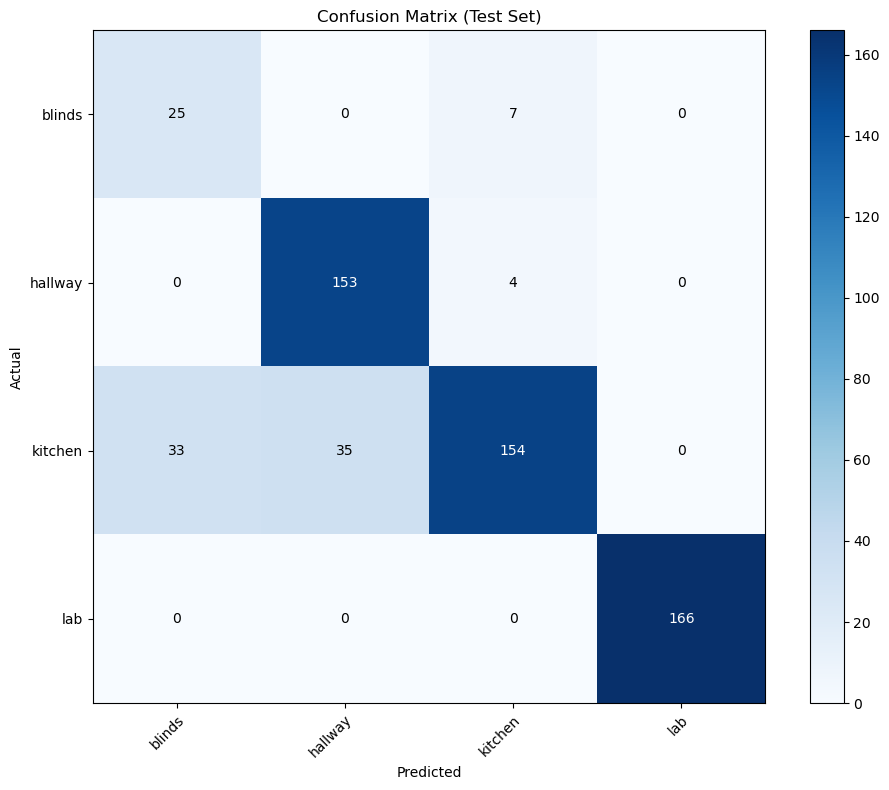

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("GRADIENT BOOSTING CLASSIFIER WITH FEATURE ENGINEERING")
print("=" * 80)

# Define common columns
COMMON_COLUMNS = [
    '% Prims Clipped', '% Prims Trivially Rejected', '% Stalled on System Memory', 
    '% Texture L2 Miss', '% Vertex Fetch Stall', 'ALU / Fragment', 'ALU / Vertex', 
    'Average Polygon Area', 'Average Vertices / Polygon', 'Avg Bytes / Fragment', 
    'Avg Bytes / Vertex', 'Avg Preemption Delay', 'Clocks / Second', 'EFU / Fragment', 
    'EFU / Vertex', 'Fragment ALU Instructions / Sec (Full)', 
    'Fragment ALU Instructions / Sec (Half)', 'Fragment EFU Instructions / Second', 
    'Fragment Instructions / Second', 'Fragments Shaded / Second', 'GPU % Bus Busy', 
    'GPU Frequency', 'L1 Texture Cache Miss Per Pixel', 'Pre-clipped Polygons/Second', 
    'Preemptions / second', 'Read Total (Bytes/sec)', 'Reused Vertices / Second', 
    'SP Memory Read (Bytes/Second)', 'Texture Memory Read BW (Bytes/Second)', 
    'Textures / Fragment', 'Textures / Vertex', 'Vertex Instructions / Second', 
    'Vertex Memory Read (Bytes/Second)', 'Vertices Shaded / Second', 
    'Write Total (Bytes/sec)', 'app_gpu_ms', 'app_rss_mb', 'app_uss_mb', 'app_vss_mb', 
    'application_layer_count', 'application_prediction_milliseconds', 'available_memory_mb', 
    'cpu_frequency_mhz', 'cpu_level', 'cpu_util_0', 'cpu_util_1', 'cpu_util_2', 
    'cpu_util_3', 'cpu_util_4', 'cpu_util_5', 'display_refresh_rate', 
    'gpu_frequency_mhz', 'gpu_level', 'gpu_util', 'mem_frequency_mhz', 
    'stale_frames_per_second', 'timewarp_gpu_ms'
]

def create_overlapping_windows(df, window_size=75, stride=25):
    """
    Create overlapping windows with stride.
    stride=25 with window_size=75 gives 66% overlap and ~3x more windows
    """
    windows = []
    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i:i+window_size].copy()
        windows.append(window)
    return windows

def extract_statistical_features(window_df):
    """
    Extract statistical features that can generalize to new data
    """
    features = []
    
    for col in window_df.columns:
        # Standard statistics
        col_data = window_df[col]
        
        features.extend([
            col_data.mean(),
            col_data.std(),
            col_data.max(),
            col_data.min(),
            col_data.median(),
            col_data.quantile(0.25),  # Q1
            col_data.quantile(0.75),  # Q3
            col_data.max() - col_data.min(),  # Range
            col_data.skew(),  # Skewness
            col_data.kurtosis()  # Kurtosis
        ])
    
    return np.array(features)

def process_dataset(metadata_df, dataset_name, window_size=75, stride=25):
    """
    Process dataset: load CSVs, create overlapping windows, extract features
    """
    all_features = []
    all_labels = []
    
    print(f"\n{'=' * 80}")
    print(f"PROCESSING {dataset_name.upper()} SET")
    print(f"{'=' * 80}\n")
    
    for idx, row in metadata_df.iterrows():
        csv_path = Path(row['filepath'])
        room_type = row['room_type']
        
        # Load CSV
        df = pd.read_csv(csv_path)
        
        # Select only common columns
        available_common = [col for col in COMMON_COLUMNS if col in df.columns]
        df = df[available_common]
        
        # Create overlapping windows
        windows = create_overlapping_windows(df, window_size, stride)
        
        print(f"{row['filename']}: {len(df)} rows → {len(windows)} windows")
        
        # Extract features from each window
        for window_df in windows:
            features = extract_statistical_features(window_df)
            all_features.append(features)
            all_labels.append(room_type)
    
    X = np.array(all_features)
    y = np.array(all_labels)
    
    print(f"\n{dataset_name.upper()} SUMMARY:")
    print(f"Total windows: {len(X)}")
    print(f"Feature vector size: {X.shape[1]} (57 sensors × 5 stats)")
    
    return X, y

# Load train and test metadata
train_metadata = pd.read_csv("meta_scan_csvs/train_metadata.csv")
test_metadata = pd.read_csv("meta_scan_csvs/test_metadata.csv")

# Process training set
X_train, y_train = process_dataset(
    train_metadata, 
    "train",
    window_size=75,
    stride=25  # 66% overlap = ~3x more windows
)

# Process testing set
X_test, y_test = process_dataset(
    test_metadata, 
    "test",
    window_size=75,
    stride=25
)

# Check class distribution
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)
print("\nTraining set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
print(train_dist)
print(f"\nTesting set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
print(test_dist)

# Scale features
print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled using StandardScaler")

# Train Gradient Boosting Classifier
print("\n" + "=" * 80)
print("TRAINING GRADIENT BOOSTING CLASSIFIER")
print("=" * 80)
print("\nHyperparameters:")
print("  - n_estimators: 200")
print("  - learning_rate: 0.05")
print("  - max_depth: 5")
print("  - random_state: 42")

clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    verbose=1
)

print("\nTraining...")
clf.fit(X_train_scaled, y_train)
print("✓ Training complete!")

# Make predictions
print("\n" + "=" * 80)
print("EVALUATION")
print("=" * 80)

y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("=" * 80)
print(classification_report(y_test, y_test_pred, digits=4))

print("\n" + "=" * 80)
print("CONFUSION MATRIX (TEST SET)")
print("=" * 80)
cm = confusion_matrix(y_test, y_test_pred)
room_types = sorted(np.unique(y_test))
cm_df = pd.DataFrame(cm, index=room_types, columns=room_types)
print(cm_df)
print("\nRows = Actual, Columns = Predicted")

# Per-class accuracy
print("\n" + "=" * 80)
print("PER-CLASS ACCURACY")
print("=" * 80)
for i, room_type in enumerate(room_types):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{room_type:12s}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Feature importance (top 20)
print("\n" + "=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 80)
feature_names = []
stats = ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75', 'range', 'skew', 'kurtosis']

for col in COMMON_COLUMNS:
    for stat in stats:
        feature_names.append(f"{col}_{stat}")

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Ticks and labels
ax.set_xticks(np.arange(len(room_types)))
ax.set_yticks(np.arange(len(room_types)))
ax.set_xticklabels(room_types)
ax.set_yticklabels(room_types)

plt.xlabel("Predicted")
plt.ylabel("Actual")

# Rotate x-labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add numbers to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("XGBOOST CLASSIFIER WITH SELECTIVE FEATURES")
print("=" * 80)

# Use only the most discriminative features (from separation analysis)
DISCRIMINATIVE_FEATURES = [
    'ALU / Fragment',
    'EFU / Fragment', 
    'Average Vertices / Polygon',
    '% Stalled on System Memory',
    'Fragment ALU Instructions / Sec (Half)',
    'Avg Bytes / Vertex',
    'Fragment ALU Instructions / Sec (Full)',
    'SP Memory Read (Bytes/Second)',
    'Write Total (Bytes/sec)',
    'Textures / Vertex',
    'Fragment Instructions / Second',
    'Reused Vertices / Second',
    'Textures / Fragment',
    'GPU % Bus Busy',
    'EFU / Vertex'
]

def create_overlapping_windows(df, window_size=75, stride=25):
    """Create overlapping windows"""
    windows = []
    for i in range(0, len(df) - window_size + 1, stride):
        window = df.iloc[i:i+window_size].copy()
        windows.append(window)
    return windows

def extract_statistical_features(window_df):
    """Extract comprehensive statistical features"""
    features = []
    
    for col in window_df.columns:
        col_data = window_df[col]
        
        features.extend([
            col_data.mean(),
            col_data.std(),
            col_data.max(),
            col_data.min(),
            col_data.median(),
            col_data.quantile(0.25),
            col_data.quantile(0.75),
            col_data.max() - col_data.min(),  # range
            col_data.skew(),
            col_data.kurtosis(),
            # Add coefficient of variation (normalized std)
            col_data.std() / (abs(col_data.mean()) + 1e-10)
        ])
    
    return np.array(features)

def process_dataset(metadata_df, dataset_name, window_size=75, stride=25):
    """Process dataset with selective features"""
    all_features = []
    all_labels = []
    
    print(f"\n{'=' * 80}")
    print(f"PROCESSING {dataset_name.upper()} SET")
    print(f"{'=' * 80}\n")
    
    for idx, row in metadata_df.iterrows():
        csv_path = Path(row['filepath'])
        room_type = row['room_type']
        
        df = pd.read_csv(csv_path)
        
        # Select only discriminative features that exist
        available_features = [col for col in DISCRIMINATIVE_FEATURES if col in df.columns]
        df = df[available_features]
        
        windows = create_overlapping_windows(df, window_size, stride)
        
        print(f"{row['filename']}: {len(df)} rows → {len(windows)} windows")
        
        for window_df in windows:
            features = extract_statistical_features(window_df)
            all_features.append(features)
            all_labels.append(room_type)
    
    X = np.array(all_features)
    y = np.array(all_labels)
    
    print(f"\n{dataset_name.upper()} SUMMARY:")
    print(f"Total windows: {len(X)}")
    print(f"Feature vector size: {X.shape[1]}")
    
    return X, y

# Load metadata
train_metadata = pd.read_csv("meta_scan_csvs/train_metadata.csv")
test_metadata = pd.read_csv("meta_scan_csvs/test_metadata.csv")

# Process datasets
X_train, y_train = process_dataset(train_metadata, "train", window_size=75, stride=25)
X_test, y_test = process_dataset(test_metadata, "test", window_size=75, stride=25)

# Class distribution
print("\n" + "=" * 80)
print("CLASS DISTRIBUTION")
print("=" * 80)
print("\nTraining set:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTesting set:")
print(pd.Series(y_test).value_counts().sort_index())

# Scale features
print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled")

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

# Train XGBoost
print("\n" + "=" * 80)
print("TRAINING XGBOOST CLASSIFIER")
print("=" * 80)
print("\nHyperparameters:")
print("  - n_estimators: 300")
print("  - learning_rate: 0.05")
print("  - max_depth: 6")
print("  - subsample: 0.8")
print("  - colsample_bytree: 0.8")
print("  - Using sample weights for class balance")

clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42,
    eval_metric='mlogloss'
)

print("\nTraining...")
clf.fit(X_train_scaled, y_train, sample_weight=sample_weights)
print("✓ Training complete!")

# Evaluate
print("\n" + "=" * 80)
print("EVALUATION")
print("=" * 80)

y_train_pred = clf.predict(X_train_scaled)
y_test_pred = clf.predict(X_test_scaled)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("=" * 80)
print(classification_report(y_test, y_test_pred, digits=4))

print("\n" + "=" * 80)
print("CONFUSION MATRIX (TEST SET)")
print("=" * 80)
cm = confusion_matrix(y_test, y_test_pred)
room_types = sorted(np.unique(y_test))
cm_df = pd.DataFrame(cm, index=room_types, columns=room_types)
print(cm_df)
print("\nRows = Actual, Columns = Predicted")

print("\n" + "=" * 80)
print("PER-CLASS ACCURACY")
print("=" * 80)
for i, room_type in enumerate(room_types):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{room_type:12s}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Feature importance
print("\n" + "=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 80)

feature_names = []
stats = ['mean', 'std', 'max', 'min', 'median', 'q25', 'q75', 'range', 'skew', 'kurtosis', 'cv']
for col in DISCRIMINATIVE_FEATURES:
    for stat in stats:
        feature_names.append(f"{col}_{stat}")

feature_importance = pd.DataFrame({
    'feature': feature_names[:len(clf.feature_importances_)],
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)

XGBOOST CLASSIFIER WITH SELECTIVE FEATURES

PROCESSING TRAIN SET

blinds_motion_5_cleaned.csv: 327 rows → 11 windows
blinds_motion_3_cleaned.csv: 335 rows → 11 windows
blinds_motion_1_cleaned.csv: 1838 rows → 71 windows
blinds_motion_4_cleaned.csv: 312 rows → 10 windows
blinds_object_5_cleaned.csv: 1827 rows → 71 windows
blinds_object_3_cleaned.csv: 327 rows → 11 windows
blinds_object_1_cleaned.csv: 1821 rows → 70 windows
blinds_object_4_cleaned.csv: 325 rows → 11 windows
blinds_person_5_cleaned.csv: 327 rows → 11 windows
blinds_person_3_cleaned.csv: 326 rows → 11 windows
blinds_person_1_cleaned.csv: 350 rows → 12 windows
blinds_person_4_cleaned.csv: 312 rows → 10 windows
hallway_5_cleaned.csv: 1493 rows → 57 windows
hallway_3_cleaned.csv: 306 rows → 10 windows
hallway_1_cleaned.csv: 300 rows → 10 windows
hallway_4_cleaned.csv: 320 rows → 10 windows
hallway_motion_5_cleaned.csv: 314 rows → 10 windows
hallway_motion_3_cleaned.csv: 313 rows → 10 windows
hallway_motion_1_cleaned.csv: 329 

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['blinds' 'hallway' 'kitchen' 'lab']